# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 100, 100)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(2000, 2, 100, 100)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(1000, 2, 100, 100)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 100, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,100,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(100, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation = custom_activation)
])


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 batch_normalization (BatchN  (None, 20000)            80000     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               2000100   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                        

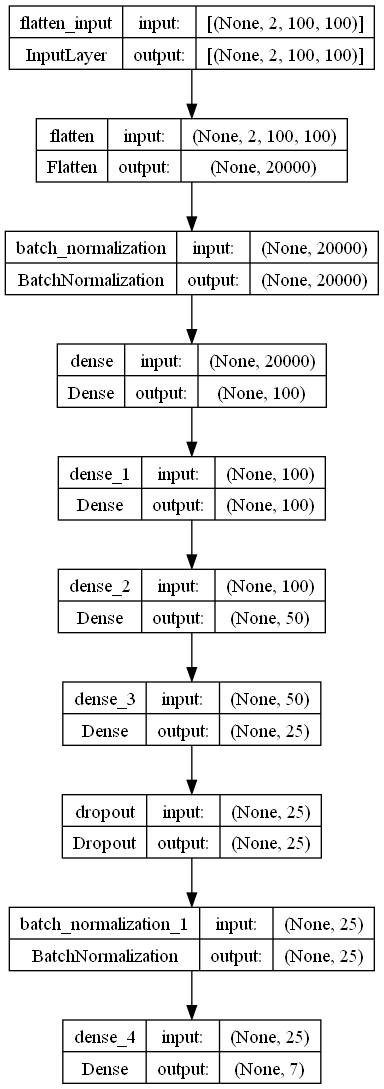

In [23]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [24]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [25]:
model.compile(optimizer=optimizer,
              loss= 'MSE',
              metrics=['mae'])

In [26]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [27]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 7s 9ms/step - loss: 14.6736 - mae: 2.1387 - val_loss: 15.4306 - val_mae: 2.5081 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 6s 9ms/step - loss: 9.4054 - mae: 1.9485 - val_loss: 7.3476 - val_mae: 1.5863 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 6s 9ms/step - loss: 7.8294 - mae: 1.8197 - val_loss: 6.2587 - val_mae: 1.4386 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 6s 9ms/step - loss: 7.0442 - mae: 1.7443 - val_loss: 4.9878 - val_mae: 1.2946 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 6s 9ms/step - loss: 6.3237 - mae: 1.6684 - val_loss: 5.2186 - val_mae: 1.3543 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 6s 9ms/step - loss: 5.9430 - mae: 1.6531 - val_loss: 4.2616 - val_mae: 1.2267 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 6s 9ms/step - loss: 5.5644 - mae: 1.6313 - val_loss: 3.9364 

700/700 [==============================] - 6s 8ms/step - loss: 4.2005 - mae: 1.5206 - val_loss: 2.8340 - val_mae: 1.0340 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.2055 - mae: 1.5236 - val_loss: 2.8000 - val_mae: 1.0457 - lr: 0.0010
Epoch 58/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.2231 - mae: 1.5268 - val_loss: 2.8216 - val_mae: 1.0500 - lr: 0.0010
Epoch 59/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.2332 - mae: 1.5286 - val_loss: 2.8048 - val_mae: 1.0240 - lr: 0.0010
Epoch 60/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.1736 - mae: 1.5127 - val_loss: 2.8879 - val_mae: 1.0686 - lr: 0.0010
Epoch 61/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.1812 - mae: 1.5176 - val_loss: 2.8004 - val_mae: 1.0406 - lr: 0.0010
Epoch 62/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.1660 - mae: 1.5094 - val_loss: 2.8030 - val_mae

700/700 [==============================] - 6s 9ms/step - loss: 3.9905 - mae: 1.4673 - val_loss: 3.1372 - val_mae: 1.2320 - lr: 0.0010
Epoch 112/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9297 - mae: 1.4450 - val_loss: 2.7904 - val_mae: 1.0412 - lr: 0.0010
Epoch 113/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9427 - mae: 1.4544 - val_loss: 2.8629 - val_mae: 1.0892 - lr: 0.0010
Epoch 114/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9489 - mae: 1.4552 - val_loss: 2.7972 - val_mae: 1.0516 - lr: 0.0010
Epoch 115/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9529 - mae: 1.4558 - val_loss: 2.8653 - val_mae: 1.0950 - lr: 0.0010
Epoch 116/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9216 - mae: 1.4474 - val_loss: 2.8582 - val_mae: 1.0940 - lr: 0.0010
Epoch 117/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9384 - mae: 1.4482 - val_loss: 2.8803 - v

700/700 [==============================] - 6s 9ms/step - loss: 3.9002 - mae: 1.4436 - val_loss: 2.7837 - val_mae: 1.0415 - lr: 0.0010
Epoch 167/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9318 - mae: 1.4506 - val_loss: 2.7272 - val_mae: 1.0195 - lr: 0.0010
Epoch 168/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9024 - mae: 1.4366 - val_loss: 2.8141 - val_mae: 1.0643 - lr: 0.0010
Epoch 169/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8706 - mae: 1.4324 - val_loss: 2.8185 - val_mae: 1.0609 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8740 - mae: 1.4338 - val_loss: 2.7709 - val_mae: 1.0270 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9433 - mae: 1.4528 - val_loss: 2.7654 - val_mae: 1.0345 - lr: 0.0010
Epoch 172/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8940 - mae: 1.4393 - val_loss: 2.8359 - v

700/700 [==============================] - 6s 9ms/step - loss: 3.9162 - mae: 1.4401 - val_loss: 2.8818 - val_mae: 1.0770 - lr: 0.0010
Epoch 222/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8826 - mae: 1.4333 - val_loss: 2.7566 - val_mae: 1.0160 - lr: 0.0010
Epoch 223/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9239 - mae: 1.4421 - val_loss: 2.7593 - val_mae: 1.0182 - lr: 0.0010
Epoch 224/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8641 - mae: 1.4301 - val_loss: 2.7297 - val_mae: 1.0159 - lr: 0.0010
Epoch 225/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9206 - mae: 1.4429 - val_loss: 2.7770 - val_mae: 1.0509 - lr: 0.0010
Epoch 226/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8617 - mae: 1.4311 - val_loss: 2.8086 - val_mae: 1.0520 - lr: 0.0010
Epoch 227/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8985 - mae: 1.4410 - val_loss: 2.7465 - v

700/700 [==============================] - 6s 9ms/step - loss: 3.8680 - mae: 1.4316 - val_loss: 2.8311 - val_mae: 1.0618 - lr: 0.0010
Epoch 277/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8926 - mae: 1.4354 - val_loss: 2.8562 - val_mae: 1.0889 - lr: 0.0010
Epoch 278/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8664 - mae: 1.4318 - val_loss: 2.8952 - val_mae: 1.0941 - lr: 0.0010
Epoch 279/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8772 - mae: 1.4347 - val_loss: 2.7493 - val_mae: 1.0452 - lr: 0.0010
Epoch 280/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8624 - mae: 1.4274 - val_loss: 2.7670 - val_mae: 1.0233 - lr: 0.0010
Epoch 281/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8777 - mae: 1.4324 - val_loss: 2.9726 - val_mae: 1.0787 - lr: 0.0010
Epoch 282/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8915 - mae: 1.4353 - val_loss: 2.9058 - v

700/700 [==============================] - 6s 9ms/step - loss: 3.8706 - mae: 1.4320 - val_loss: 2.8015 - val_mae: 1.0507 - lr: 0.0010
Epoch 332/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8514 - mae: 1.4272 - val_loss: 3.0217 - val_mae: 1.1492 - lr: 0.0010
Epoch 333/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8494 - mae: 1.4245 - val_loss: 2.7428 - val_mae: 1.0148 - lr: 0.0010
Epoch 334/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8754 - mae: 1.4365 - val_loss: 2.8619 - val_mae: 1.1043 - lr: 0.0010
Epoch 335/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8810 - mae: 1.4335 - val_loss: 2.7325 - val_mae: 1.0126 - lr: 0.0010
Epoch 336/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.8721 - mae: 1.4315 - val_loss: 2.8206 - val_mae: 1.0446 - lr: 0.0010
Epoch 337/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8648 - mae: 1.4246 - val_loss: 2.7327 - v

700/700 [==============================] - 6s 9ms/step - loss: 3.8998 - mae: 1.4381 - val_loss: 2.9285 - val_mae: 1.1449 - lr: 0.0010
Epoch 387/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8647 - mae: 1.4306 - val_loss: 2.7474 - val_mae: 1.0217 - lr: 0.0010
Epoch 388/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8785 - mae: 1.4303 - val_loss: 2.8556 - val_mae: 1.0855 - lr: 0.0010
Epoch 389/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.8690 - mae: 1.4302 - val_loss: 2.8154 - val_mae: 1.0457 - lr: 0.0010
Epoch 390/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8729 - mae: 1.4307 - val_loss: 2.7839 - val_mae: 1.0281 - lr: 0.0010
Epoch 391/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.8787 - mae: 1.4326 - val_loss: 2.7538 - val_mae: 1.0207 - lr: 0.0010
Epoch 392/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8542 - mae: 1.4274 - val_loss: 2.7705 - v

700/700 [==============================] - 6s 8ms/step - loss: 3.8401 - mae: 1.4296 - val_loss: 2.7546 - val_mae: 1.0183 - lr: 9.3565e-04
Epoch 441/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.8250 - mae: 1.4253 - val_loss: 2.7502 - val_mae: 1.0134 - lr: 9.3400e-04
Epoch 442/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.8302 - mae: 1.4251 - val_loss: 2.9550 - val_mae: 1.1266 - lr: 9.3235e-04
Epoch 443/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.8542 - mae: 1.4300 - val_loss: 2.8529 - val_mae: 1.0885 - lr: 9.3070e-04
Epoch 444/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8411 - mae: 1.4287 - val_loss: 2.8080 - val_mae: 1.0422 - lr: 9.2905e-04
Epoch 445/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.8309 - mae: 1.4279 - val_loss: 2.7547 - val_mae: 1.0273 - lr: 9.2740e-04
Epoch 446/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8556 - mae: 1.433

Epoch 494/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7922 - mae: 1.4208 - val_loss: 2.6661 - val_mae: 0.9935 - lr: 8.4655e-04
Epoch 495/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8010 - mae: 1.4215 - val_loss: 2.6339 - val_mae: 0.9853 - lr: 8.4490e-04
Epoch 496/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8017 - mae: 1.4251 - val_loss: 2.7624 - val_mae: 1.0657 - lr: 8.4325e-04
Epoch 497/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7800 - mae: 1.4195 - val_loss: 2.7610 - val_mae: 1.0334 - lr: 8.4160e-04
Epoch 498/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7839 - mae: 1.4176 - val_loss: 2.7422 - val_mae: 1.0353 - lr: 8.3995e-04
Epoch 499/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8298 - mae: 1.4303 - val_loss: 2.7383 - val_mae: 1.0593 - lr: 8.3830e-04
Epoch 500/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.79

700/700 [==============================] - 6s 9ms/step - loss: 3.7423 - mae: 1.4149 - val_loss: 2.6310 - val_mae: 1.0048 - lr: 7.5910e-04
Epoch 548/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.7781 - mae: 1.4200 - val_loss: 2.6509 - val_mae: 1.0037 - lr: 7.5745e-04
Epoch 549/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.7545 - mae: 1.4202 - val_loss: 2.7257 - val_mae: 1.0537 - lr: 7.5580e-04
Epoch 550/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7647 - mae: 1.4192 - val_loss: 2.7523 - val_mae: 1.0505 - lr: 7.5415e-04
Epoch 551/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7963 - mae: 1.4267 - val_loss: 2.6467 - val_mae: 1.0261 - lr: 7.5250e-04
Epoch 552/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7455 - mae: 1.4169 - val_loss: 2.6440 - val_mae: 0.9897 - lr: 7.5085e-04
Epoch 553/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7876 - mae: 1.428

Epoch 601/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7027 - mae: 1.4097 - val_loss: 2.5703 - val_mae: 0.9795 - lr: 6.7000e-04
Epoch 602/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7246 - mae: 1.4178 - val_loss: 2.6364 - val_mae: 1.0238 - lr: 6.6835e-04
Epoch 603/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7038 - mae: 1.4103 - val_loss: 2.5773 - val_mae: 0.9818 - lr: 6.6670e-04
Epoch 604/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7324 - mae: 1.4173 - val_loss: 2.6524 - val_mae: 1.0198 - lr: 6.6505e-04
Epoch 605/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7302 - mae: 1.4181 - val_loss: 2.6192 - val_mae: 1.0152 - lr: 6.6340e-04
Epoch 606/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7311 - mae: 1.4158 - val_loss: 2.5694 - val_mae: 0.9663 - lr: 6.6175e-04
Epoch 607/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.69

700/700 [==============================] - 6s 9ms/step - loss: 3.6870 - mae: 1.4100 - val_loss: 2.5758 - val_mae: 1.0064 - lr: 5.8255e-04
Epoch 655/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7070 - mae: 1.4150 - val_loss: 2.5883 - val_mae: 0.9912 - lr: 5.8090e-04
Epoch 656/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6793 - mae: 1.4066 - val_loss: 2.5946 - val_mae: 1.0089 - lr: 5.7925e-04
Epoch 657/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6733 - mae: 1.4111 - val_loss: 2.6517 - val_mae: 1.0664 - lr: 5.7760e-04
Epoch 658/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6967 - mae: 1.4142 - val_loss: 2.5231 - val_mae: 0.9516 - lr: 5.7595e-04
Epoch 659/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6606 - mae: 1.4014 - val_loss: 2.6391 - val_mae: 1.0469 - lr: 5.7430e-04
Epoch 660/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6992 - mae: 1.414

Epoch 708/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6837 - mae: 1.4155 - val_loss: 2.5248 - val_mae: 0.9844 - lr: 4.9345e-04
Epoch 709/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6551 - mae: 1.4118 - val_loss: 2.6044 - val_mae: 1.0215 - lr: 4.9180e-04
Epoch 710/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6446 - mae: 1.4084 - val_loss: 2.5412 - val_mae: 0.9775 - lr: 4.9015e-04
Epoch 711/1000
700/700 [==============================] - 7s 10ms/step - loss: 3.6451 - mae: 1.4093 - val_loss: 2.5164 - val_mae: 0.9825 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6473 - mae: 1.4100 - val_loss: 2.5266 - val_mae: 0.9949 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6373 - mae: 1.4089 - val_loss: 2.5171 - val_mae: 0.9776 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6

700/700 [==============================] - 6s 9ms/step - loss: 3.6447 - mae: 1.4092 - val_loss: 2.4831 - val_mae: 0.9636 - lr: 4.0600e-04
Epoch 762/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6105 - mae: 1.4050 - val_loss: 2.5637 - val_mae: 1.0117 - lr: 4.0435e-04
Epoch 763/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6248 - mae: 1.4054 - val_loss: 2.5232 - val_mae: 0.9946 - lr: 4.0270e-04
Epoch 764/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6564 - mae: 1.4186 - val_loss: 2.4583 - val_mae: 0.9575 - lr: 4.0105e-04
Epoch 765/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5868 - mae: 1.4010 - val_loss: 2.6044 - val_mae: 1.0497 - lr: 3.9940e-04
Epoch 766/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6088 - mae: 1.4042 - val_loss: 2.4471 - val_mae: 0.9292 - lr: 3.9775e-04
Epoch 767/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6222 - mae: 1.407

700/700 [==============================] - 7s 10ms/step - loss: 3.5721 - mae: 1.3994 - val_loss: 2.4338 - val_mae: 0.9308 - lr: 3.1855e-04
Epoch 815/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5587 - mae: 1.3953 - val_loss: 2.4350 - val_mae: 0.9461 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.5623 - mae: 1.4013 - val_loss: 2.4473 - val_mae: 0.9573 - lr: 3.1525e-04
Epoch 817/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.5647 - mae: 1.3991 - val_loss: 2.4124 - val_mae: 0.9112 - lr: 3.1360e-04
Epoch 818/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.5837 - mae: 1.4010 - val_loss: 2.4524 - val_mae: 0.9570 - lr: 3.1195e-04
Epoch 819/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.6227 - mae: 1.4117 - val_loss: 2.4490 - val_mae: 0.9572 - lr: 3.1030e-04
Epoch 820/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.5859 - mae: 1.40

700/700 [==============================] - 7s 9ms/step - loss: 3.5585 - mae: 1.3974 - val_loss: 2.4028 - val_mae: 0.9418 - lr: 2.3110e-04
Epoch 868/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.5406 - mae: 1.3960 - val_loss: 2.3856 - val_mae: 0.9292 - lr: 2.2945e-04
Epoch 869/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.5234 - mae: 1.3910 - val_loss: 2.4063 - val_mae: 0.9459 - lr: 2.2780e-04
Epoch 870/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.5201 - mae: 1.3938 - val_loss: 2.4123 - val_mae: 0.9474 - lr: 2.2615e-04
Epoch 871/1000
700/700 [==============================] - 7s 10ms/step - loss: 3.5869 - mae: 1.4099 - val_loss: 2.4004 - val_mae: 0.9267 - lr: 2.2450e-04
Epoch 872/1000
700/700 [==============================] - 7s 10ms/step - loss: 3.5400 - mae: 1.3979 - val_loss: 2.3973 - val_mae: 0.9275 - lr: 2.2285e-04
Epoch 873/1000
700/700 [==============================] - 7s 10ms/step - loss: 3.5576 - mae: 1.

700/700 [==============================] - 6s 9ms/step - loss: 3.5110 - mae: 1.3934 - val_loss: 2.3428 - val_mae: 0.8895 - lr: 1.4365e-04
Epoch 921/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5192 - mae: 1.3938 - val_loss: 2.3660 - val_mae: 0.9116 - lr: 1.4200e-04
Epoch 922/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.4971 - mae: 1.3923 - val_loss: 2.3661 - val_mae: 0.9146 - lr: 1.4035e-04
Epoch 923/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5171 - mae: 1.3958 - val_loss: 2.3410 - val_mae: 0.8992 - lr: 1.3870e-04
Epoch 924/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5176 - mae: 1.3975 - val_loss: 2.3566 - val_mae: 0.9077 - lr: 1.3705e-04
Epoch 925/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.4892 - mae: 1.3871 - val_loss: 2.3552 - val_mae: 0.9118 - lr: 1.3540e-04
Epoch 926/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5107 - mae: 1.395

700/700 [==============================] - 7s 10ms/step - loss: 3.4812 - mae: 1.3939 - val_loss: 2.3151 - val_mae: 0.8924 - lr: 5.6200e-05
Epoch 974/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5010 - mae: 1.3961 - val_loss: 2.3106 - val_mae: 0.8831 - lr: 5.4550e-05
Epoch 975/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.4855 - mae: 1.3909 - val_loss: 2.3143 - val_mae: 0.8848 - lr: 5.2900e-05
Epoch 976/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.4537 - mae: 1.3821 - val_loss: 2.3121 - val_mae: 0.8849 - lr: 5.1250e-05
Epoch 977/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.5076 - mae: 1.3956 - val_loss: 2.3264 - val_mae: 0.9115 - lr: 4.9600e-05
Epoch 978/1000
700/700 [==============================] - 7s 9ms/step - loss: 3.4984 - mae: 1.3938 - val_loss: 2.3104 - val_mae: 0.8822 - lr: 4.7950e-05
Epoch 979/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.4887 - mae: 1.39

# Analizamos accuracy y loss

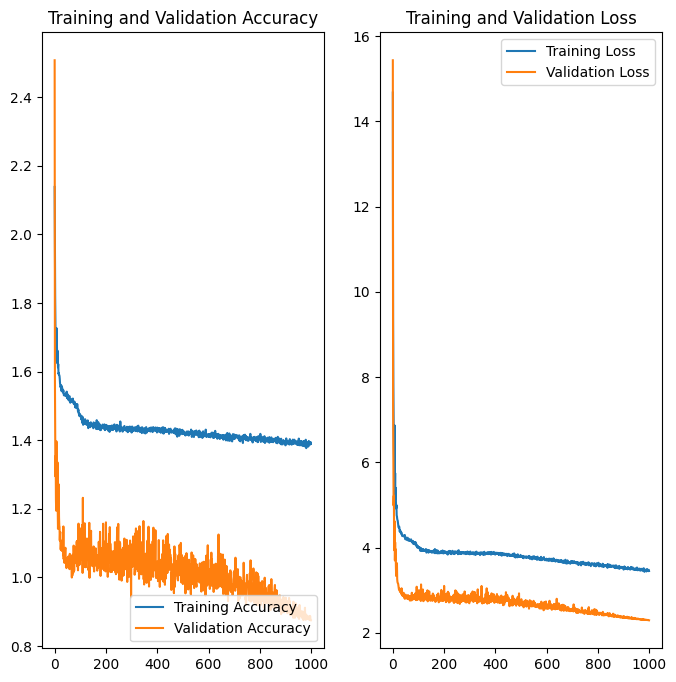

In [28]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [29]:
test_loss, test_acc = model.evaluate(campvecval,coefcampvecval)

32/32 [==============================] - 0s 3ms/step - loss: 2.2964 - mae: 0.8749


In [30]:
predictions = model.predict(campvecval)

32/32 [==============================] - 0s 2ms/step


In [31]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvecval, predictions)

# Calcula la desviación estándar del error
error = coefcampvecval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 0.8748677802720506, Desviación estándar del error: 1.5008642772187981, Error absoluto máximo: 5.485762596130371


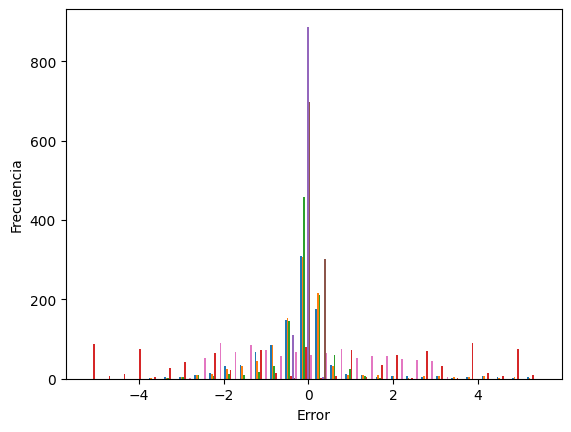

In [32]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [33]:
from sklearn.metrics import r2_score

r2 = r2_score(coefcampvecval, predictions)
r2

0.684894481255407

In [34]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

2.6580675363540656

# Guardamos los datos de Accuracy y Loss

In [35]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 100,200/historycampvec100.csv', index=False)

# Guardamos el modelo

In [36]:
path_to_save = '../../../Modelos/Modelos 100,200'

In [37]:
model.save(path_to_save + '/campovectorial100.h5')

# Importamos el modelo

In [41]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/campovectorial100.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [42]:
import random
from scipy.integrate import solve_ivp

campvec = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)

--------------------------------------------
[2, 2, 0, 6, 7, 9, 2]


In [43]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [44]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 52ms/step
[[2. 2. 0. 5. 7. 9. 2.]]


## Encontramos puntos de equilibrio datos reales

In [45]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(0.2740070266731986, 0.20670299241912005)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

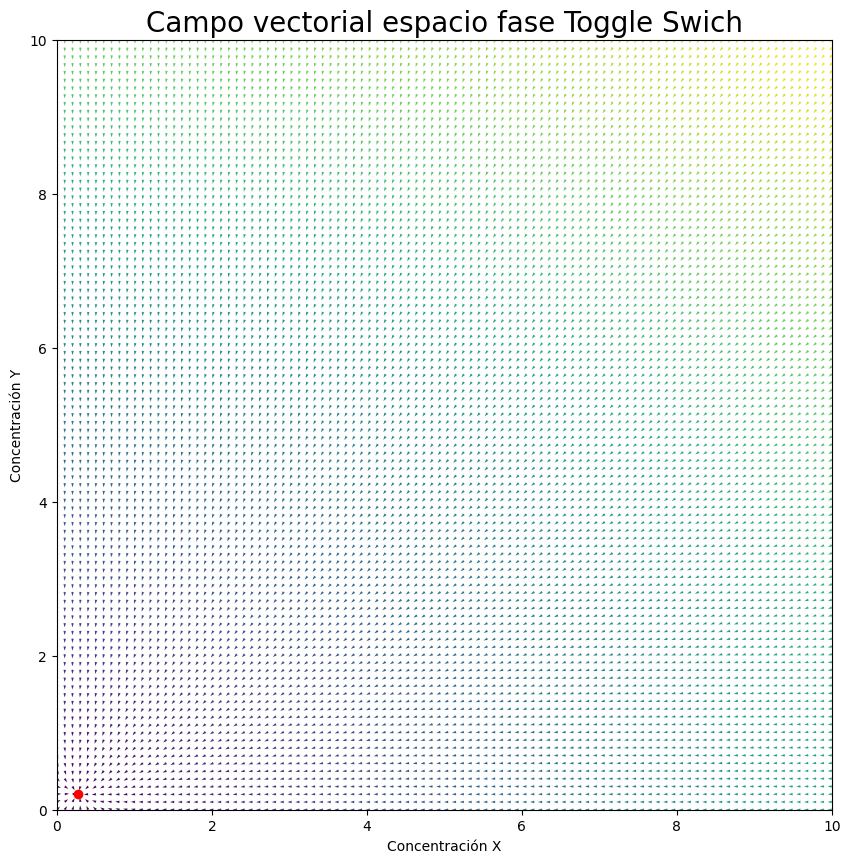

In [46]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 100)
y2 = np.linspace(0, 10, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [47]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(0.2740070266731986, 0.20670299241912005)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

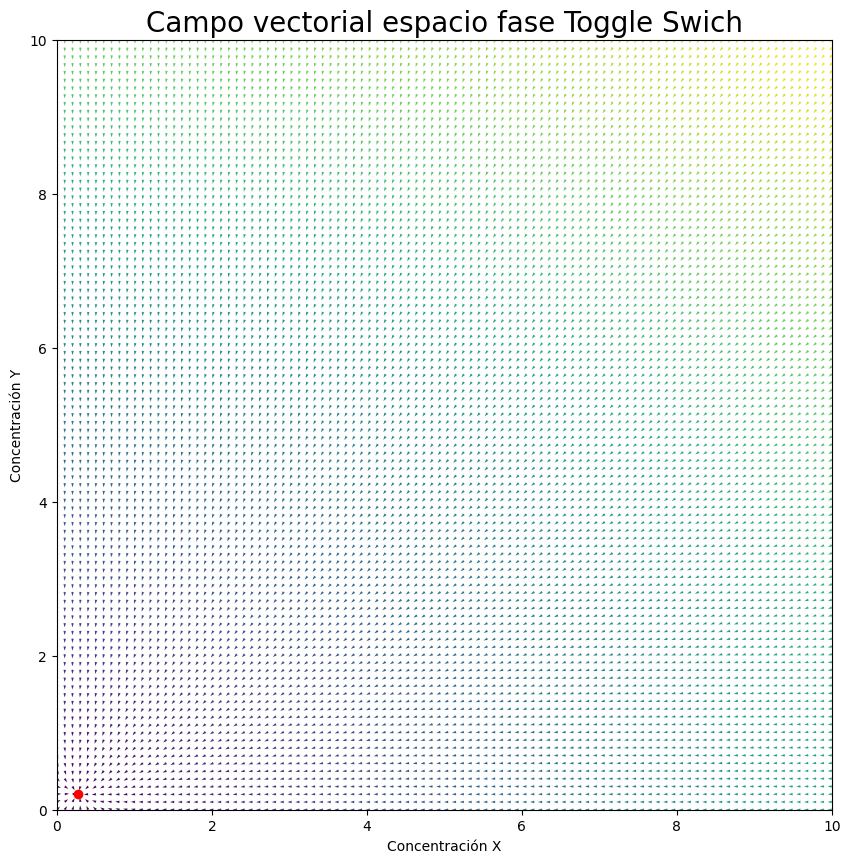

In [48]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 100)
y2pred = np.linspace(y_range_neg, y_range_pos, 100)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

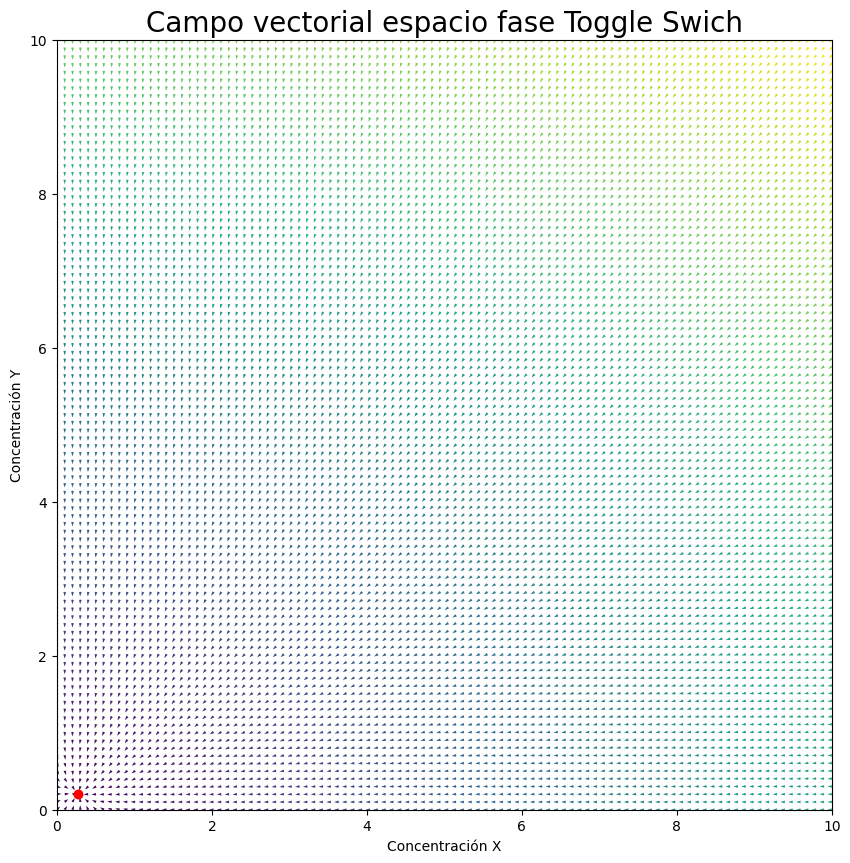

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

0.0


C:\Users\rafae\anaconda3\envs\tfcpu\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\rafae\anaconda3\envs\tfcpu\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


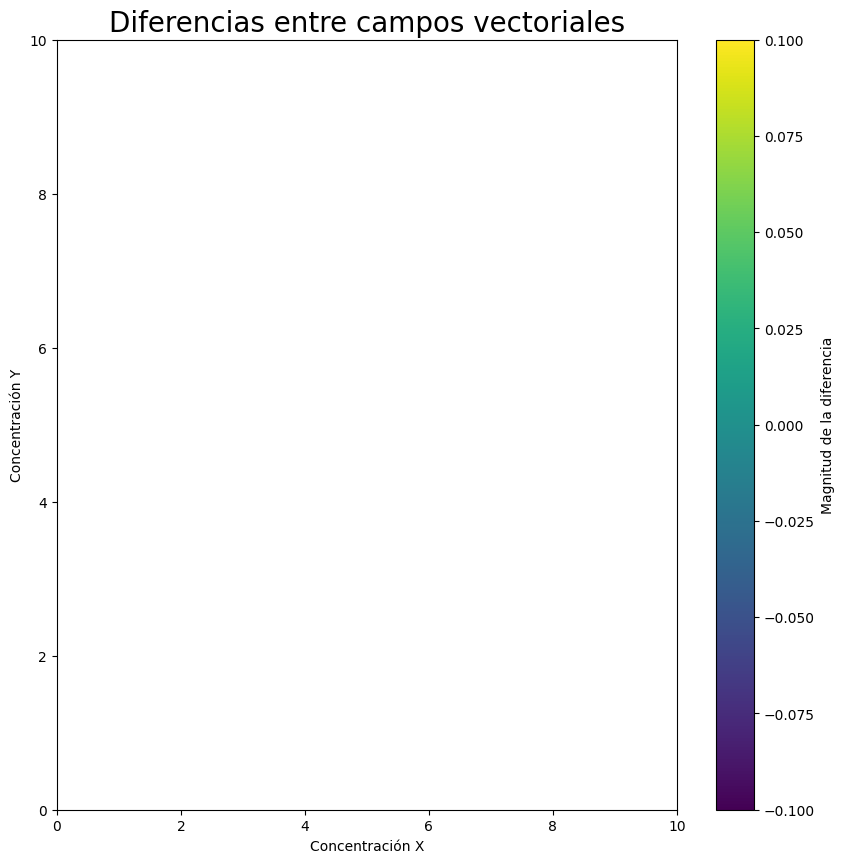

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

## Errores relativos 

C:\Users\rafae\anaconda3\envs\tfcpu\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\rafae\anaconda3\envs\tfcpu\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


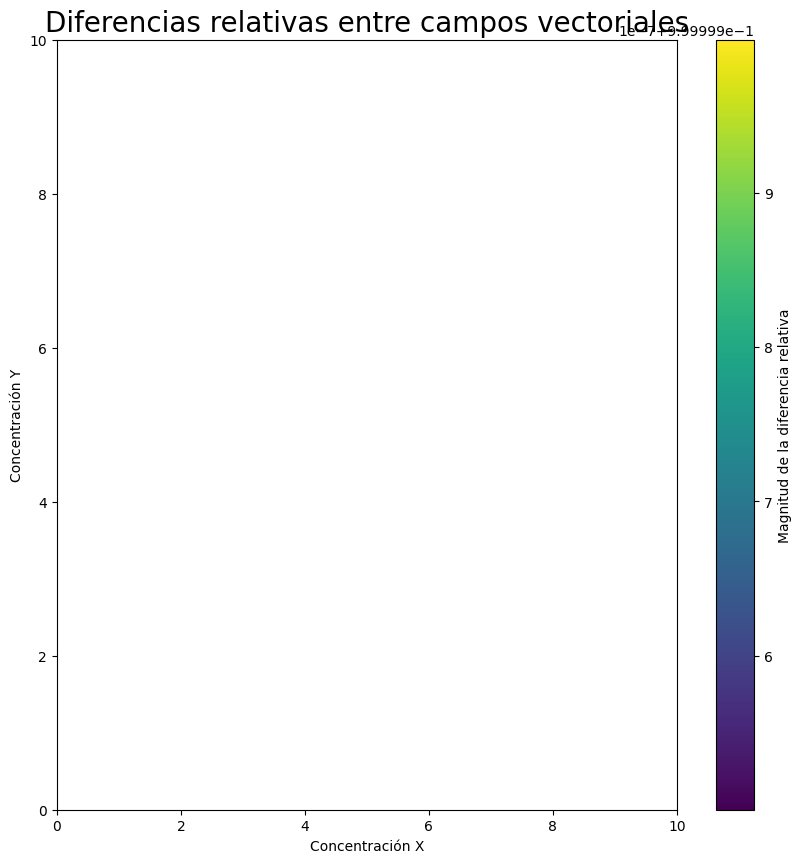

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [52]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 0.9999999991227282
El valor de u1 en el error relativo máximo es: -69.98019801980197
El valor de u1pred en el error relativo máximo es: -69.98019801980197
El valor de v1 en el error relativo máximo es: -89.98019801980197
El valor de v1pred en el error relativo máximo es: -89.98019801980197
